# **Import Dependencies**

In [26]:
import warnings
warnings.filterwarnings('ignore')

import zipfile
import hashlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import uuid
import re
import random
import cv2
import numpy as np
import tensorflow as tf
import seaborn as sns
from google.colab import drive
from google.colab import files
from pathlib import Path
from PIL import Image, ImageStat, UnidentifiedImageError, ImageEnhance
from matplotlib import patches
from tqdm import tqdm
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_fscore_support, auc

print(tf.__version__)

2.19.0


In [2]:
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/Animals.zip'
extract_to = '/content/my_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

Mounted at /content/drive


# **Convert Dataset to a Data Frame**

In [3]:
image_extensions = {'.jpg', '.jpeg', '.png'}
paths = [(path.parts[-2], path.name, str(path)) for path in Path(extract_to).rglob('*.*') if path.suffix.lower() in image_extensions]

df = pd.DataFrame(paths, columns = ['class', 'image', 'full_path'])
df = df.sort_values('class', ascending = True)
df.reset_index(drop = True, inplace = True)
df

class       image                                   full_path
0       cats  0_0654.jpg    /content/my_data/Animals/cats/0_0654.jpg
1       cats  0_0686.jpg    /content/my_data/Animals/cats/0_0686.jpg
2       cats  0_0246.jpg    /content/my_data/Animals/cats/0_0246.jpg
3       cats  0_0742.jpg    /content/my_data/Animals/cats/0_0742.jpg
4       cats  0_0258.jpg    /content/my_data/Animals/cats/0_0258.jpg
...      ...         ...                                         ...
2995  snakes  2_0878.jpg  /content/my_data/Animals/snakes/2_0878.jpg
2996  snakes  2_0062.jpg  /content/my_data/Animals/snakes/2_0062.jpg
2997  snakes  2_0810.jpg  /content/my_data/Animals/snakes/2_0810.jpg
2998  snakes  2_0259.jpg  /content/my_data/Animals/snakes/2_0259.jpg
2999  snakes  2_0779.jpg  /content/my_data/Animals/snakes/2_0779.jpg

[3000 rows x 3 columns]

# **EDA Process**

In [4]:
class_count = df['class'].value_counts()
for cls, count in class_count.items():
    print(f'Class: {cls}, Count: {count} images')

print(f"\nTotal dataset size is: {len(df)} images")
print(f"Number of classes: {df['class'].nunique()} classes")

Class: cats, Count: 1000 images
Class: dogs, Count: 1000 images
Class: snakes, Count: 1000 images

Total dataset size is: 3000 images
Number of classes: 3 classes


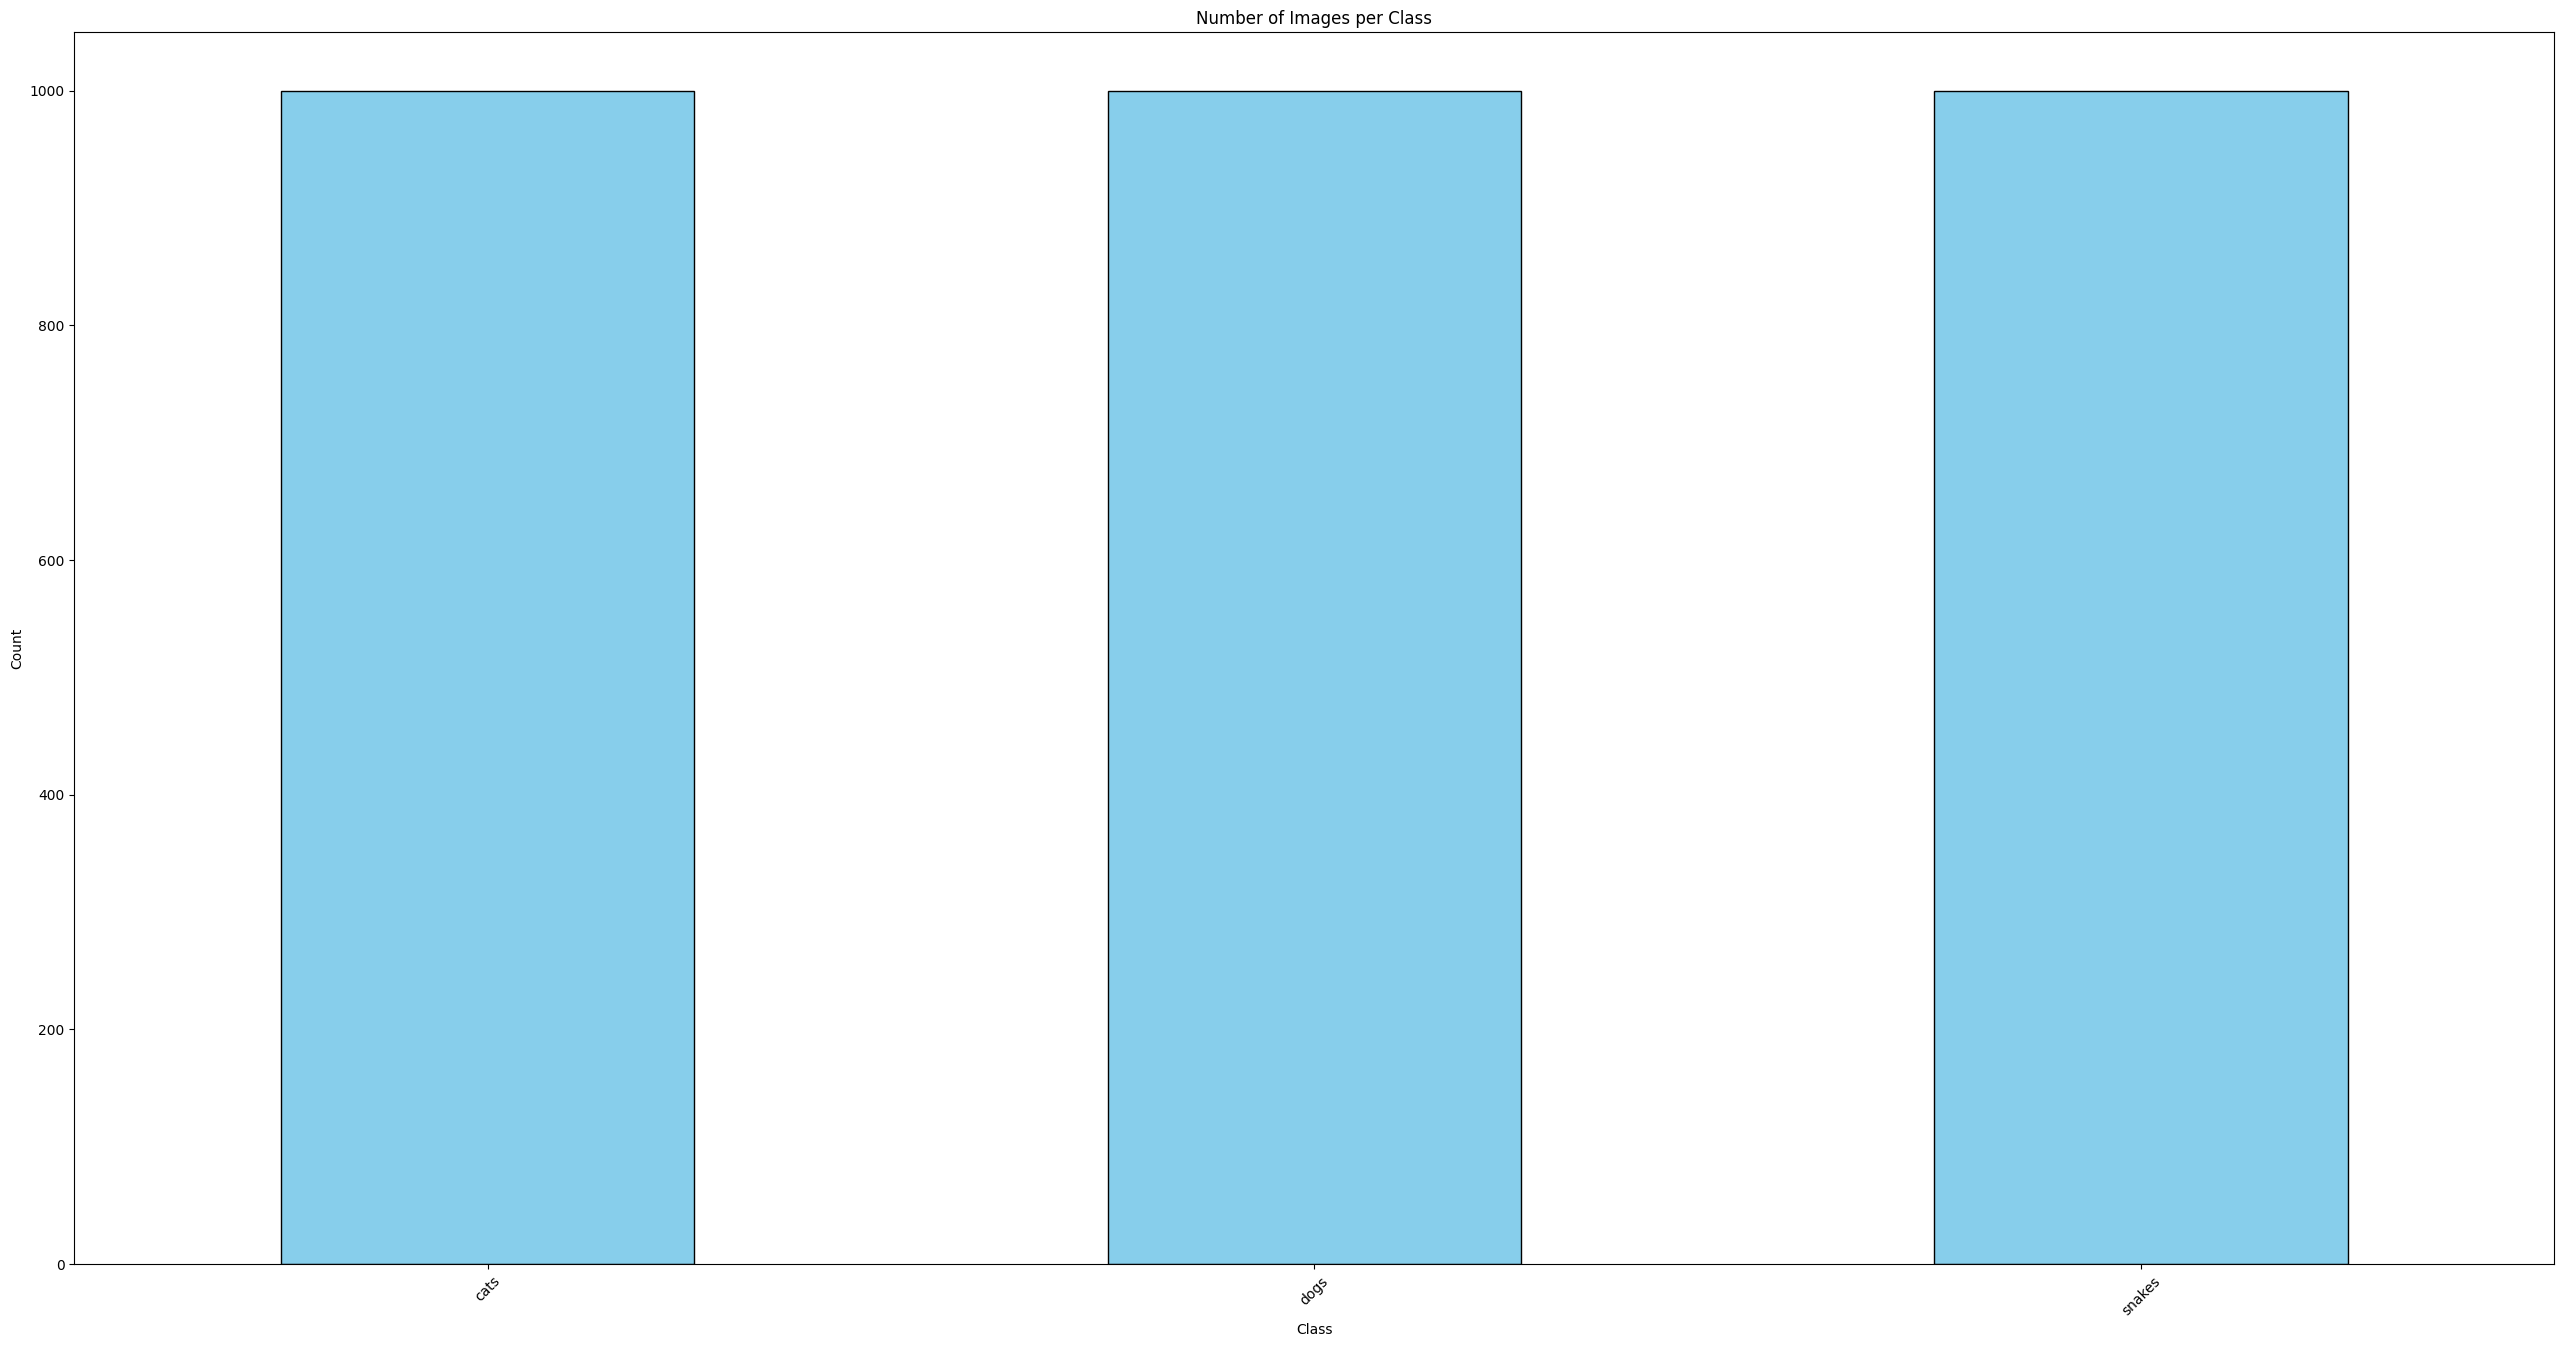

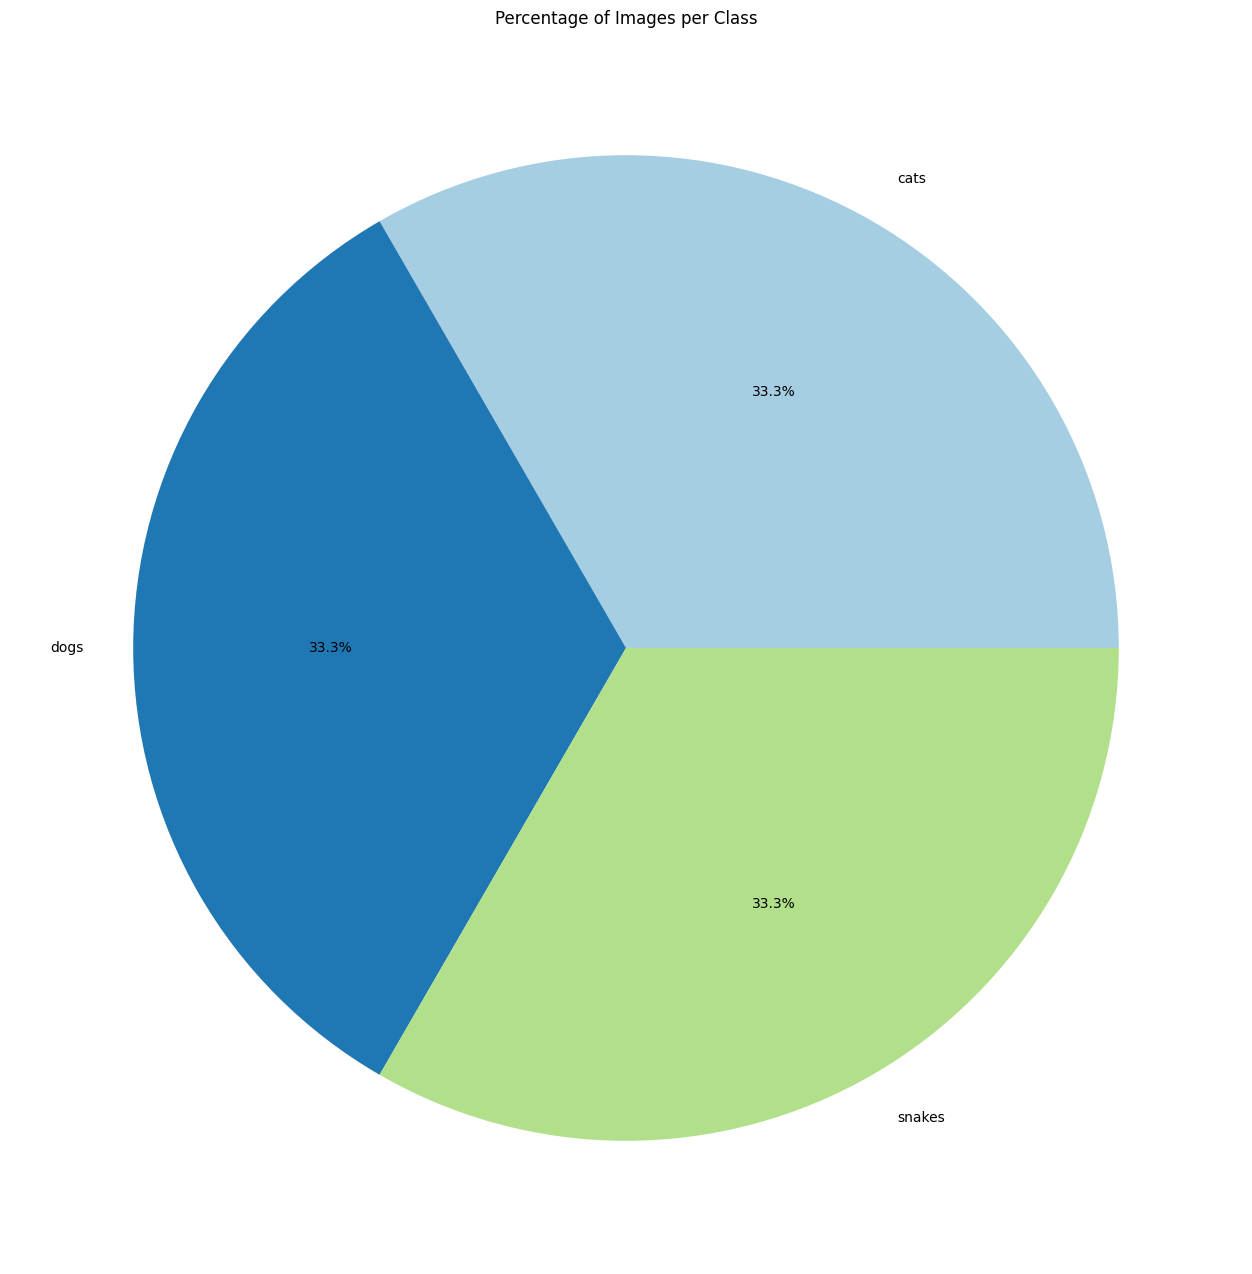

In [5]:
plt.figure(figsize = (32, 16))
class_count.plot(kind = 'bar', color = 'skyblue', edgecolor = 'black')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (32, 16))
class_count.plot(kind = 'pie', autopct = '%1.1f%%', colors = plt.cm.Paired.colors)
plt.title('Percentage of Images per Class')
plt.ylabel('')
plt.show()

        Count  Percentage %
class                      
cats     1000         33.33
dogs     1000         33.33
snakes   1000         33.33


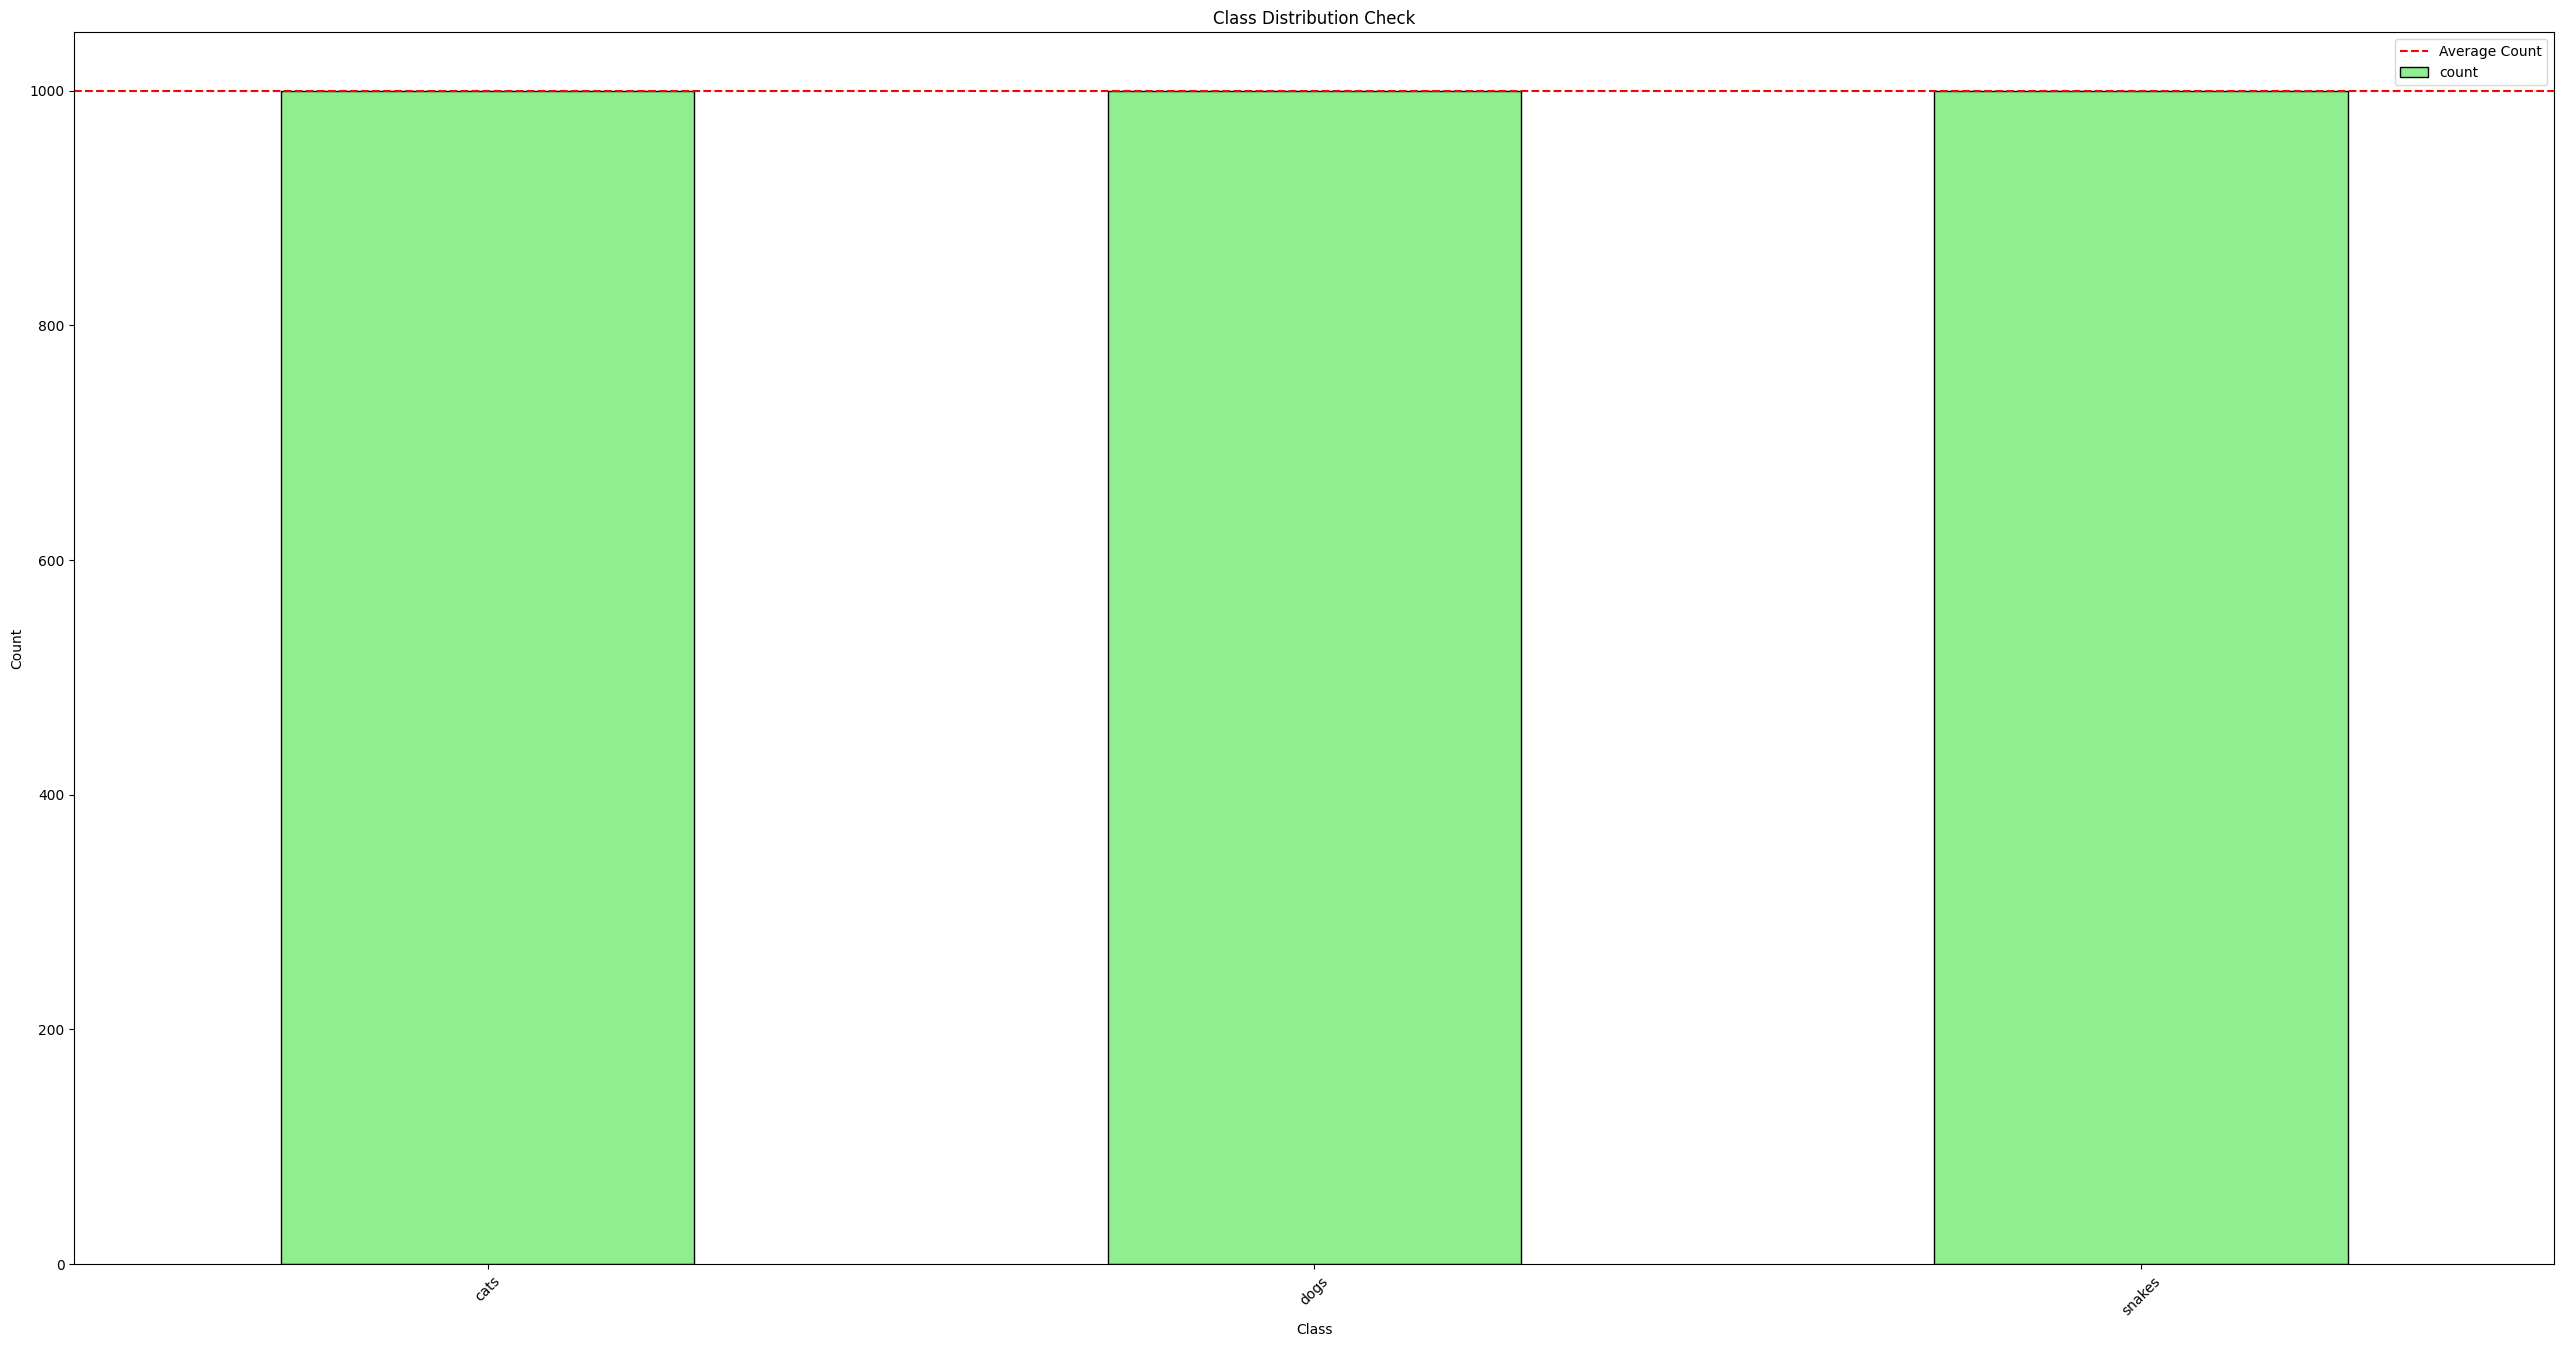

In [6]:
percentages = (class_count / len(df)) * 100
imbalance_df = pd.DataFrame({'Count': class_count, 'Percentage %': percentages.round(2)})
print(imbalance_df)

plt.figure(figsize = (32, 16))
class_count.plot(kind = 'bar', color = 'lightgreen', edgecolor = 'black')
plt.title('Class Distribution Check')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.axhline(y = class_count.mean(), color = 'red', linestyle = '--', label = 'Average Count')
plt.legend()
plt.show()

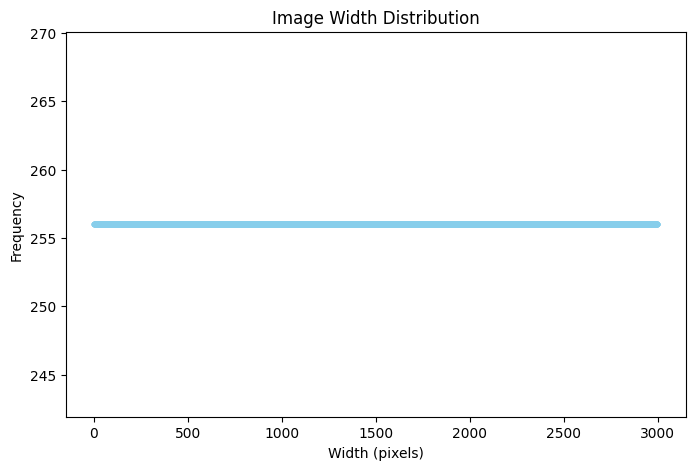

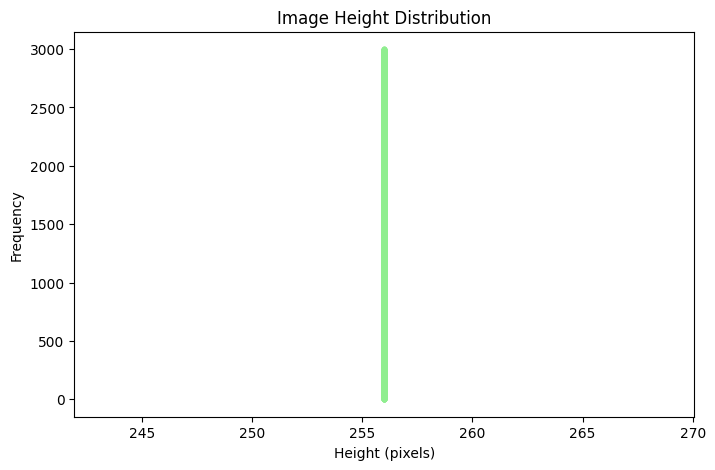

   Width  Height  Count
0    256     256   3000
Image Mode Distribution:
Mode
RGB    3000
Name: count, dtype: int64

Number of Channels Distribution:
Channels
3    3000
Name: count, dtype: int64


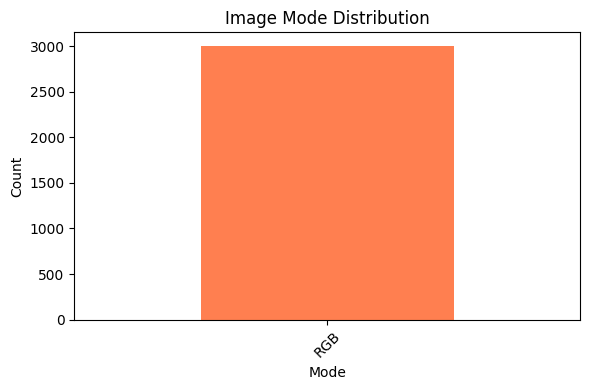

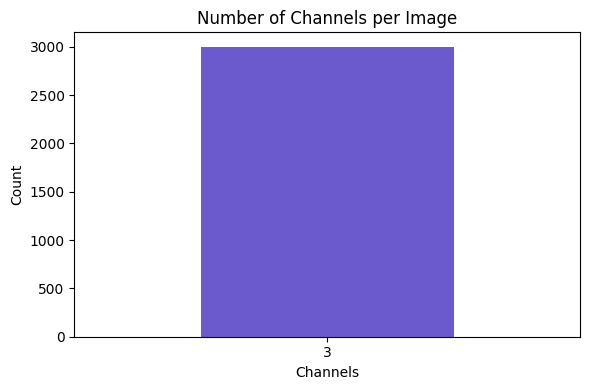

In [7]:
image_sizes = []

for file_path in df['full_path']:
    with Image.open(file_path) as img:
        image_sizes.append(img.size)

sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

#Width
plt.figure(figsize=(8,5))
plt.scatter(x = range(len(sizes_df)), y = sizes_df['Width'], color='skyblue', s=10)
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.show()

#Height
plt.figure(figsize=(8,5))
plt.scatter(x = sizes_df['Height'], y = range(len(sizes_df)), color='lightgreen', s=10)
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.show()

#For best sure the size of the whole images
unique_sizes = sizes_df.value_counts().reset_index(name='Count')
print(unique_sizes)

image_data = []

for file_path in df['full_path']:
    with Image.open(file_path) as img:
        width, height = img.size
        mode = img.mode  # e.g., 'RGB', 'L', 'RGBA', etc.
        channels = len(img.getbands())  # Number of channels
        image_data.append((width, height, mode, channels))

# Create DataFrame
image_df = pd.DataFrame(image_data, columns=['Width', 'Height', 'Mode', 'Channels'])

print("Image Mode Distribution:")
print(image_df['Mode'].value_counts())

print("\nNumber of Channels Distribution:")
print(image_df['Channels'].value_counts())

plt.figure(figsize=(6,4))
image_df['Mode'].value_counts().plot(kind='bar', color='coral')
plt.title("Image Mode Distribution")
plt.xlabel("Mode")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
image_df['Channels'].value_counts().sort_index().plot(kind='bar', color='slateblue')
plt.title("Number of Channels per Image")
plt.xlabel("Channels")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Image: 1_0814.jpg | Class: dogs | Size: 256x256 | Brightness: 99.4 | Contrast: 50.2
Image: 1_0061.jpg | Class: dogs | Size: 256x256 | Brightness: 152.4 | Contrast: 48.7
Image: 1_0763.jpg | Class: dogs | Size: 256x256 | Brightness: 88.7 | Contrast: 63.4
Image: 0_0644.jpg | Class: cats | Size: 256x256 | Brightness: 120.5 | Contrast: 64.3
Image: 2_0485.jpg | Class: snakes | Size: 256x256 | Brightness: 87.9 | Contrast: 61.6
Image: 1_0645.jpg | Class: dogs | Size: 256x256 | Brightness: 58.5 | Contrast: 22.6
Image: 1_0583.jpg | Class: dogs | Size: 256x256 | Brightness: 126.6 | Contrast: 64.6
Image: 2_0717.jpg | Class: snakes | Size: 256x256 | Brightness: 145.8 | Contrast: 92.9
Image: 0_0158.jpg | Class: cats | Size: 256x256 | Brightness: 100.6 | Contrast: 61.2
Image: 2_0623.jpg | Class: snakes | Size: 256x256 | Brightness: 175.7 | Contrast: 77.5


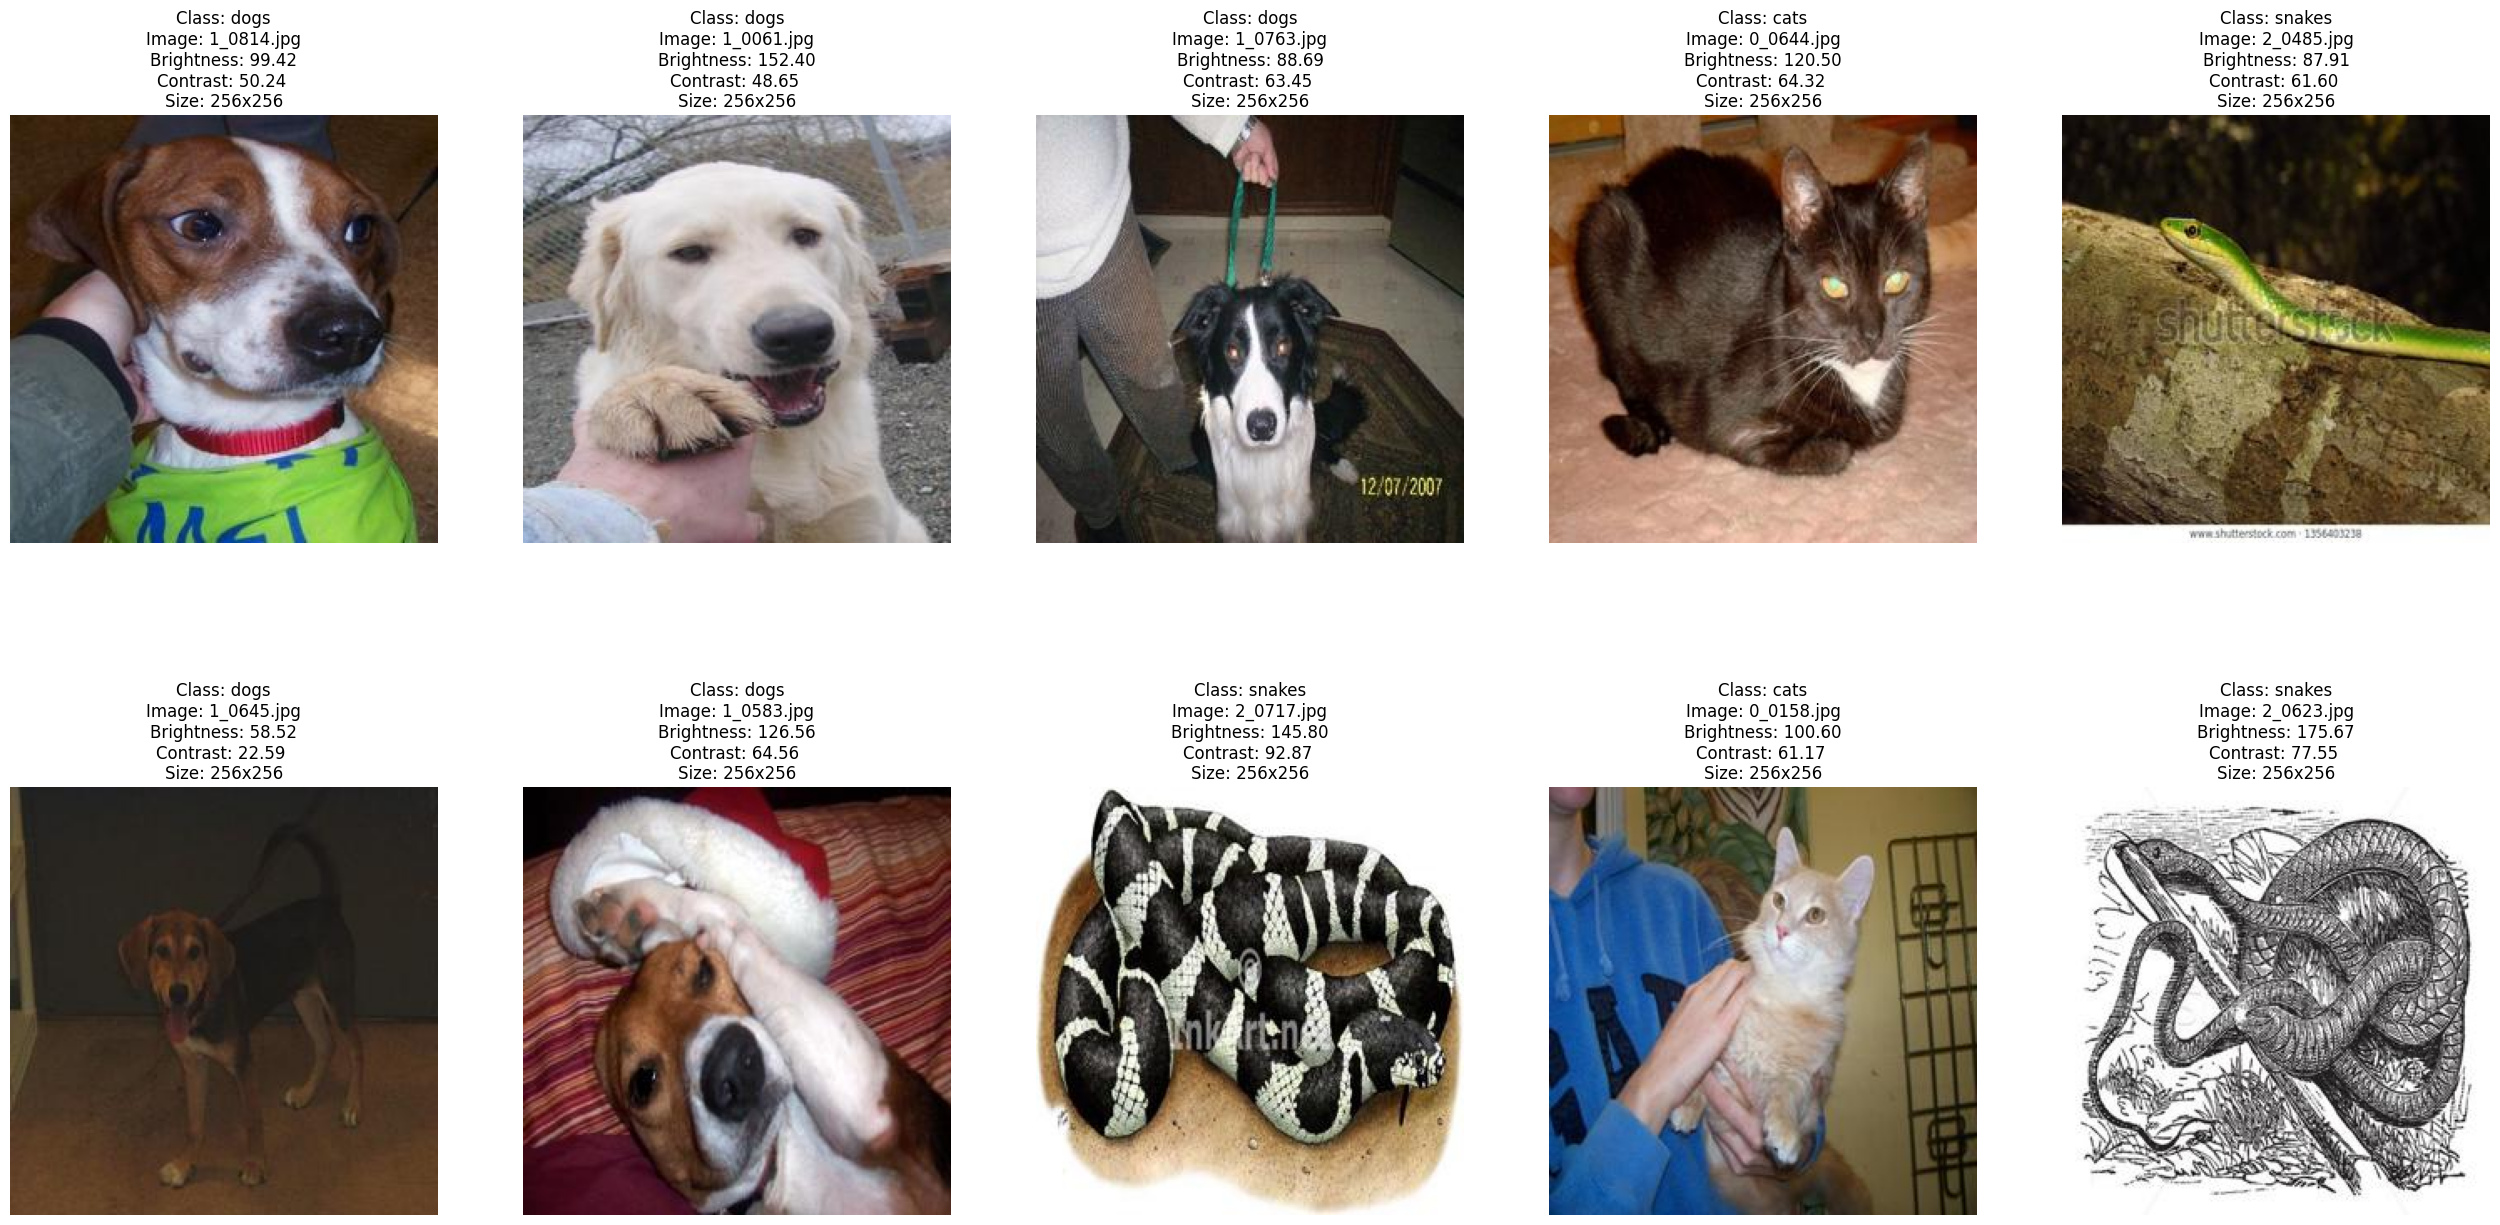

In [8]:
sample_df = df.sample(n = 10, random_state = 42)

plt.figure(figsize=(32, 16))

for i, (cls, img_name, full_path) in enumerate(sample_df.values):
    with Image.open(full_path) as img:
      stat = ImageStat.Stat(img.convert("RGB")) #Convert images to RGB images
      brightness = stat.mean[0]
      contrast = stat.stddev[0]

      width, height = img.size
      # Print size to console
      print(f"Image: {img_name} | Class: {cls} | Size: {width}x{height} | Brightness: {brightness:.1f} | Contrast: {contrast:.1f}")

      plt.subplot(2, 5, i + 1)
      plt.imshow(img)
      plt.axis('off')
      plt.title(f"Class: {cls}\nImage: {img_name}\nBrightness: {brightness:.2f}\nContrast: {contrast:.2f} \nSize: {width}x{height}")

plt.tight_layout
plt.show()

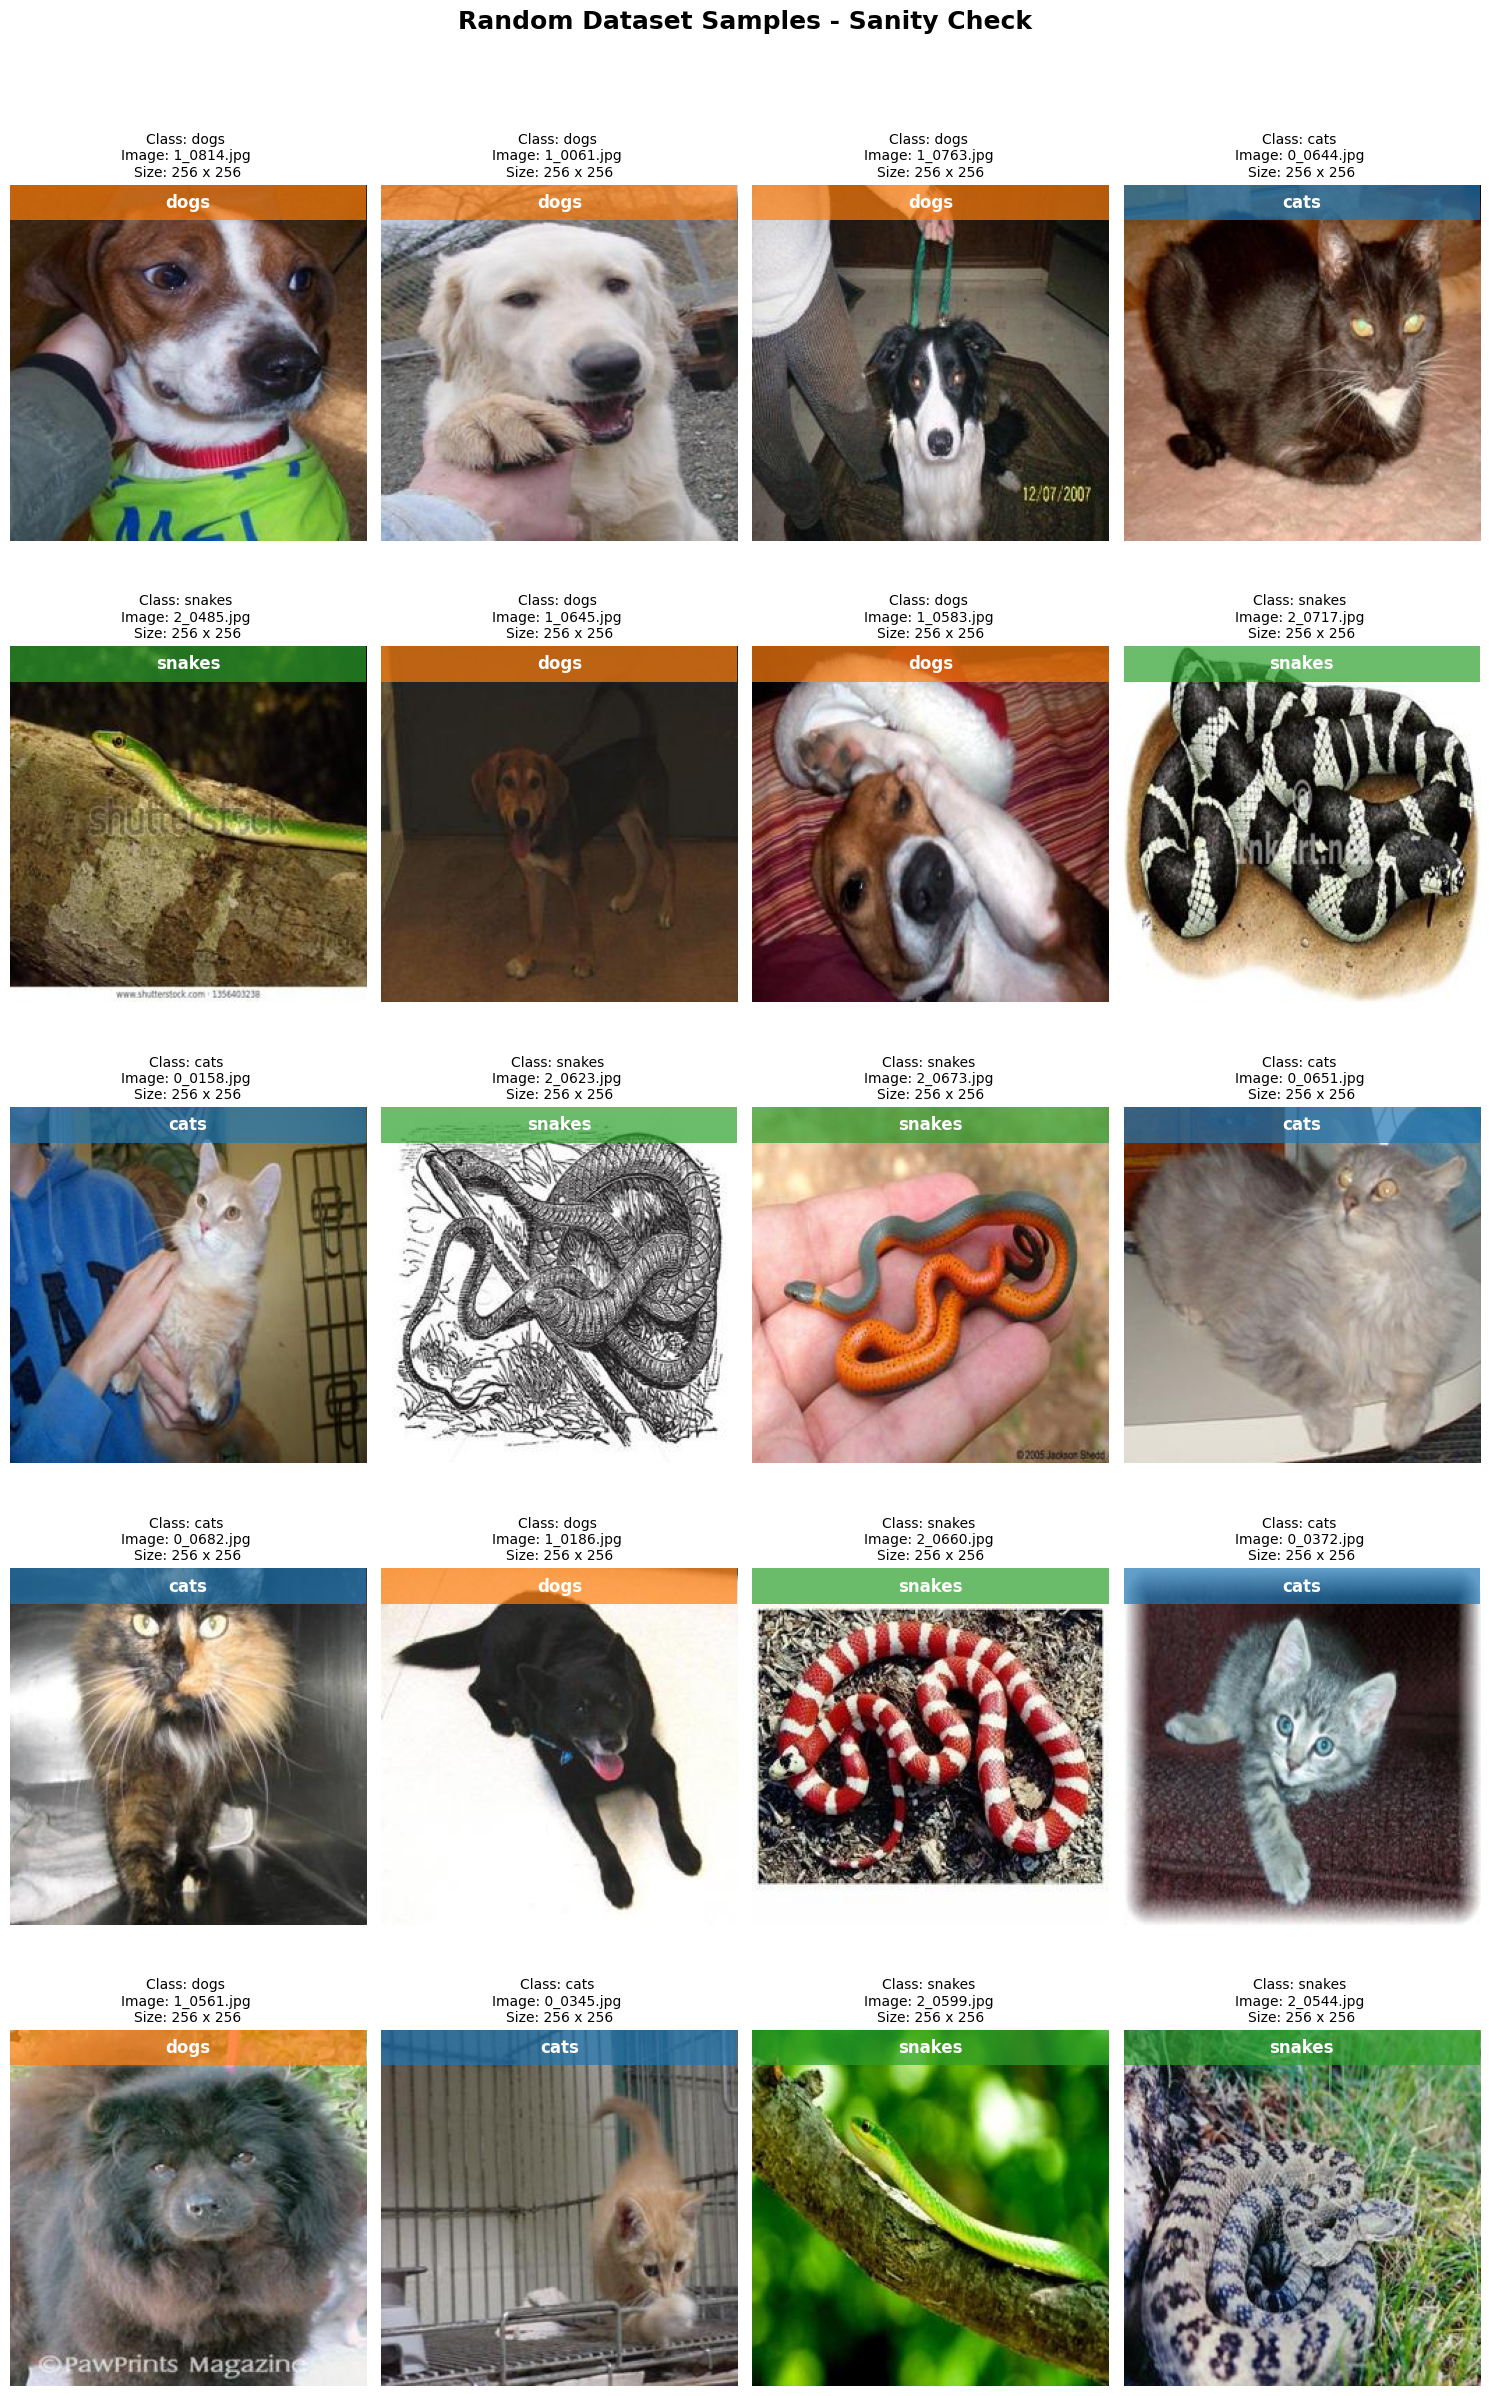

In [9]:
# Sample 20 random images
num_samples = 20
sample_df = df.sample(num_samples, random_state=42)

# Get sorted class list and color map
classes = sorted(df['class'].unique())
colors = plt.cm.tab10.colors

# Grid setup
cols = 4
rows = num_samples // cols + int(num_samples % cols > 0)

# Figure setup
plt.figure(figsize=(15, 5 * rows))

for idx, (cls, img_name, full_path) in enumerate(sample_df.values):
    with Image.open(full_path) as img:
        ax = plt.subplot(rows, cols, idx + 1)
        ax.imshow(img)
        ax.axis('off')

        # Title with class info
        ax.set_title(
            f"Class: {cls} \nImage: {img_name} \nSize: {img.width} x {img.height}",
            fontsize=10
        )

        # Rectangle in axes coords: full width, small height at top
        label_height = 0.1  # 10% of image height
        label_width = 1.0   # full width of the image

        rect = patches.Rectangle(
        (0, 1 - label_height), label_width, label_height,
        transform=ax.transAxes,
        linewidth=0,
        edgecolor=None,
        facecolor=colors[classes.index(cls) % len(colors)],
        alpha=0.7
      )
        ax.add_patch(rect)

        # Add class name text centered horizontally
        ax.text(
        0.5, 1 - label_height / 2,
        cls,
        transform=ax.transAxes,
        fontsize=12,
        color="white",
        fontweight="bold",
        va="center",
        ha="center"
      )

# Figure title and layout
plt.suptitle("Random Dataset Samples - Sanity Check", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [10]:
#Check missing files
print("Missing values per column: ")
print(df.isnull().sum())

#Check duplicate files
duplicate_names = df.duplicated().sum()
print(f"\nNumber of duplicate files: {duplicate_names}")

duplicate_names = df[df.duplicated(subset = ['image'], keep = False)]
print(f"Duplicate file names: {len(duplicate_names)}")

#Check if two images or more are the same even if they are having different file names
def get_hash(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

df['file_hash'] = df['full_path'].apply(get_hash)
duplicate_hashes = df[df.duplicated(subset = ['file_hash'], keep = False)]
print(f"Duplicate image files: {len(duplicate_hashes)}")

#This code below just removing the duplicate files, which means will not be feeded to the model, but will be still in the actual directory
#Important note: duplicates are removed from the dataframe only, not from the actual directory.
#Drop duplicates based on file_hash, keeping the first one

# df_unique = df.drop_duplicates(subset='file_hash', keep='first')
# print(f"After removing duplicates, unique images: {len(df_unique)}")

#Check for images extentions
df['extenstion'] = df['image'].apply(lambda x: Path(x).suffix.lower())
print("File type counts: ")
#print(df['extenstion'].value_counts)
print(df['extenstion'].value_counts())

#Check for resolution relationships
df['Width'] = sizes_df['Width']
df['Height'] = sizes_df['Height']
#print(df.groupby(['Width', 'Height']).size())
print(df.groupby('class')[['Width', 'Height']].agg(['min', 'max', 'mean']))

#Check for class balance (relationship between label and count)
class_summary = df['class'].value_counts(normalize = False).to_frame('Count')
#class_summary['Percentage'] = class_summary['Count'] / class_summary['Count'].sum() * 100
#class_summary
class_summary['Percentage %'] = round((class_summary['Count'] / len(df)) * 100, 2)
print(class_summary)

Missing values per column: 
class        0
image        0
full_path    0
dtype: int64

Number of duplicate files: 0
Duplicate file names: 0
Duplicate image files: 2
File type counts: 
extenstion
.jpg    3000
Name: count, dtype: int64
       Width             Height            
         min  max   mean    min  max   mean
class                                      
cats     256  256  256.0    256  256  256.0
dogs     256  256  256.0    256  256  256.0
snakes   256  256  256.0    256  256  256.0
        Count  Percentage %
class                      
cats     1000         33.33
dogs     1000         33.33
snakes   1000         33.33


# **Data Cleaning Process**

In [11]:
corrupted_files = []

for file_path in df['full_path']:
    try:
        with Image.open(file_path) as img:
            img.verify()
    except (UnidentifiedImageError, OSError):
        corrupted_files.append(file_path)

print(f"Found {len(corrupted_files)} corrupted images.")
    #except (IOError, SyntaxError) as e:
        #corrupted_files.append(file_path)

#print(f"Number of corrupted files: {len(corrupted_files)}")

if corrupted_files:
  df = df[~df['full_path'].isin(corrupted_files)].reset_index(drop = True)
  print("Corrupted files removed.")

#Outliers detection
#Resolution-based outlier detection
#width_mean = width_std = sizes_df['Width'].mean(), sizes_df['Width'].std()
#height_mean = height_std = sizes_df['Height'].mean(), sizes_df['Height'].std()

width_mean = sizes_df['Width'].mean()
width_std = sizes_df['Width'].std()
height_mean = sizes_df['Height'].mean()
height_std = sizes_df['Height'].std()

outliers = df[(df['Width'] > width_mean + 3 * width_std) | (df['Width'] < width_mean - 3 * width_std) | (df['Height'] > height_mean + 3 * height_std) | (df['Height'] < height_mean - 3 * height_std)]
#print(f"Number of outliers: {len(outliers)}")
print(f"Found {len(outliers)} resolution outliers.")

df["image"] = df["full_path"].apply(lambda p: Image.open(p).convert('RGB')) #Convert it to RGB for flexibility

too_dark = []
too_bright = []
blank_or_gray = []

# Thresholds
dark_threshold = 30    # Below this is too dark
bright_threshold = 225 # Above this is too bright
low_contrast_threshold = 5  # Low contrast ~ blank/gray

for idx, img in enumerate(df["image"]):
    gray = img.convert('L')
    stat = ImageStat.Stat(gray) # Convert to grayscale for brightness/contrast analysis
    brightness = stat.mean[0]
    contrast = stat.stddev[0]

    if brightness < dark_threshold:
        too_dark.append(idx)
    elif brightness > bright_threshold:
        too_bright.append(idx)
    elif contrast < low_contrast_threshold:
        blank_or_gray.append(idx)

print(f"Too dark images: {len(too_dark)}")
print(f"Too bright images: {len(too_bright)}")
print(f"Blank/gray images: {len(blank_or_gray)}")

# df = df.drop(index=too_bright + blank_or_gray).reset_index(drop=True) --> DROPS too_bright + blank_or_gray TOGETHER!

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Enhancing images"):
    img = row["image"]

    # Enhance too dark images
    if row["full_path"] in df.loc[too_dark, "full_path"].values:
        img = ImageEnhance.Brightness(img).enhance(1.5)  # Increase brightness
        img = ImageEnhance.Contrast(img).enhance(1.5)    # Increase contrast

    # Decrease brightness for too bright images
    if row["full_path"] in df.loc[too_bright, "full_path"].values:
        img = ImageEnhance.Brightness(img).enhance(0.7)  # Decrease brightness (less than 1)
        img = ImageEnhance.Contrast(img).enhance(1.2)    # Optionally, you can also enhance contrast

    # Overwrite the image back into the DataFrame
    df.at[idx, "image"] = img

print(f"Enhanced images in memory: {len(df)}")

# Lists to store paths of still too dark and too bright images
still_dark = []
still_bright = []

# Threshold for "too bright" (already defined as bright_threshold)
for idx, img in enumerate(df["image"]):
    gray = img.convert('L')  # Convert to grayscale for brightness analysis
    stat = ImageStat.Stat(gray)
    brightness = stat.mean[0]

    # Check if the image is still too dark
    if brightness < dark_threshold:
        still_dark.append(df.loc[idx, 'full_path'])

    # Check if the image is too bright
    if brightness > bright_threshold:
        still_bright.append(df.loc[idx, 'full_path'])

print(f"Still too dark after enhancement: {len(still_dark)} images")
print(f"Still too bright after enhancement: {len(still_bright)} images")

Found 0 corrupted images.
Found 0 resolution outliers.
Too dark images: 9
Too bright images: 24
Blank/gray images: 0


Enhancing images: 100%|██████████| 3000/3000 [00:02<00:00, 1354.82it/s]


Enhanced images in memory: 3000
Still too dark after enhancement: 2 images
Still too bright after enhancement: 0 images


In [ ]:
# Point to the extracted dataset, not the zip file location
dataset_root = "/content/my_data/Animals"

# Check mislabeled images
mismatches = []
for i, row in df.iterrows():
    folder_name = os.path.basename(os.path.dirname(row["full_path"]))
    if row["class"] != folder_name:
        mismatches.append((row["full_path"], row["class"], folder_name))

print(f"Found {len(mismatches)} mislabeled images (class vs folder mismatch).")

# Compare classes vs folders
classes_in_df = set(df["class"].unique())
folders_in_fs = {f for f in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, f))}

print("Classes in DF but not in folders:", classes_in_df - folders_in_fs)
print("Folders in FS but not in DF:", folders_in_fs - classes_in_df)

Found 0 mislabeled images (class vs folder mismatch).
Classes in DF but not in folders: set()
Folders in FS but not in DF: set()


In [12]:
def check_file_naming_issues(df):
    issues = {"invalid_chars": [], "spaces": [], "long_paths": [], "case_conflicts": [], "duplicate_names_across_classes": []}

    seen_names = {}

    for _, row in df.iterrows():
        fpath = row["full_path"]              # full path
        fname = os.path.basename(fpath)       # just filename
        cls = row["class"]

        if re.search(r'[<>:"/\\|?*]', fname):  # Windows restricted chars
            issues["invalid_chars"].append(fpath)

        if "  " in fname or fname.startswith(" ") or fname.endswith(" "):
            issues["spaces"].append(fpath)

        if len(fpath) > 255:
            issues["long_paths"].append(fpath)

        lower_name = fname.lower()
        if lower_name in seen_names and seen_names[lower_name] != cls:
            issues["case_conflicts"].append((fpath, seen_names[lower_name]))
        else:
            seen_names[lower_name] = cls

    duplicates = df.groupby(df["full_path"].apply(os.path.basename))["class"].nunique()
    duplicates = duplicates[duplicates > 1].index.tolist()
    for dup in duplicates:
        dup_paths = df[df["full_path"].str.endswith(dup)]["full_path"].tolist()
        issues["duplicate_names_across_classes"].extend(dup_paths)

    return issues

# Run the check
naming_issues = check_file_naming_issues(df)

for issue_type, files in naming_issues.items():
    print(f"\n{issue_type.upper()} ({len(files)})")
    for f in files[:10]:  # preview first 10
        print(f)


INVALID_CHARS (0)

SPACES (0)

LONG_PATHS (0)

CASE_CONFLICTS (0)

DUPLICATE_NAMES_ACROSS_CLASSES (0)


# **Data Preprocessing Process**

In [13]:
def preprocess_image(path, target_size=(256, 256), augment=True):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0

    if augment and tf.random.uniform(()) < 0.1:  # Only 10% chance
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    return img

In [14]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['class'])

# Prepare paths and labels
paths = df['full_path'].values
labels = df['label'].values

Dataset sizes:
Train: 2430 images
Validation: 270 images
Test: 300 images
--------------------------------------------------
Train labels sample: [0 1 1 0 0 0 2 2 0 2]
Validation labels sample: [2 2 2 0 0 1 1 1 0 0]
Test labels sample: [0 0 1 2 2 2 2 1 1 1]
Image dtype: <dtype: 'float32'>
Min pixel value: 0.0
Max pixel value: 0.8392157
Label: 1


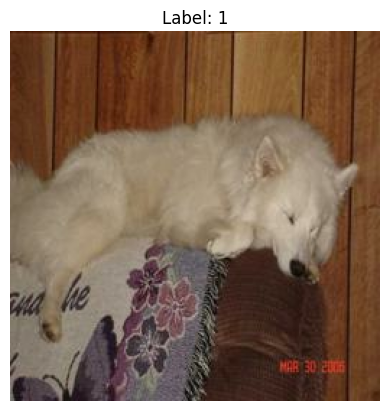

---------------------------------------------------
Number of Classes:  3


In [15]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

# Split data into train+val and test (10% test)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    paths, labels, test_size=0.1, random_state=42, stratify=labels
)

# Split train+val into train and val (10% of train_val as val)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.1, random_state=42, stratify=train_val_labels
)

# Create datasets
def load_and_preprocess(path, label):
    return preprocess_image(path), label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(lambda x, y: (preprocess_image(x, augment=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1024).batch(batch_size).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(AUTOTUNE)

print("Dataset sizes:")
print(f"Train: {len(train_paths)} images")
print(f"Validation: {len(val_paths)} images")
print(f"Test: {len(test_paths)} images")
print("--------------------------------------------------")
print("Train labels sample:", train_labels[:10])
print("Validation labels sample:", val_labels[:10])
print("Test labels sample:", test_labels[:10])

# Preview normalized image stats and visualization
for image_batch, label_batch in train_ds.take(1):
    # Print pixel value stats for first image in the batch
    image = image_batch[0]
    label = label_batch[0]
    print("Image dtype:", image.dtype)
    print("Min pixel value:", tf.reduce_min(image).numpy())
    print("Max pixel value:", tf.reduce_max(image).numpy())
    print("Label:", label.numpy())

    # Show the image
    plt.imshow(image.numpy())
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')
    plt.show()
print("---------------------------------------------------")
print("Number of Classes: ", len(le.classes_))

In [16]:
# After train_ds is defined
for image_batch, label_batch in train_ds.take(1):
    print("Image batch shape:", image_batch.shape)  # full batch shape
    print("Label batch shape:", label_batch.shape)  # labels shape

    input_shape = image_batch.shape[1:]  # shape of a single image
    print("Single image shape:", input_shape)
    break

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)
Single image shape: (256, 256, 3)


# **Model Loading**

In [17]:
inception = InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)

# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

# Number of classes
print("Number of Classes: ", len(le.classes_))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Number of Classes:  3


In [18]:
x = GlobalAveragePooling2D()(inception.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(len(le.classes_), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 22,853,411 (87.18 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [19]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# **Model Feature Extraction**

In [20]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True,  verbose = 1),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss',  verbose = 1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=callbacks, verbose = 1)

Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8509 - loss: 0.4330
Epoch 1: val_loss improved from inf to 0.06660, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 49s 410ms/step - accuracy: 0.8521 - loss: 0.4298 - val_accuracy: 0.9741 - val_loss: 0.0666 - learning_rate: 0.0010
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9722 - loss: 0.0880
Epoch 2: val_loss improved from 0.06660 to 0.05993, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.9722 - loss: 0.0881 - val_accuracy: 0.9741 - val_loss: 0.0599 - learning_rate: 0.0010
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9845 - loss: 0.0572
Epoch 3: val_loss did not improve from 0.05993
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.9845 - loss: 0.0572 - val_accuracy: 0.9741 - val_loss: 0.0714 - learning_rate: 0.0010
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9905 - loss: 0.0337
Epoch 4: val_loss did not improve from 0.05993

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9905 - loss: 0.0340 - val_accuracy: 0.9667 - val_loss: 0.0852 - learning_rate: 0.0010
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9866 - loss: 0.0362
Epoch 5: val_loss improved from 0.05993 to 0.02748, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.9867 - loss: 0.0362 - val_accuracy: 0.9889 - val_loss: 0.0275 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 5.


# **Model Fine-Tuning**

In [22]:
#Fine Tuning
for layer in inception.layers[-30:]: # Unfreeze last 30 layers (tune as needed)
    layer.trainable = True

# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,  verbose = 1),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss',  verbose = 1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5, verbose=1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks, verbose = 1)

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9950 - loss: 0.0395
Epoch 1: val_loss improved from inf to 0.15426, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 374ms/step - accuracy: 0.9950 - loss: 0.0395 - val_accuracy: 0.9852 - val_loss: 0.1543 - learning_rate: 0.0010
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9968 - loss: 0.0215
Epoch 2: val_loss improved from 0.15426 to 0.04965, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9968 - loss: 0.0216 - val_accuracy: 0.9926 - val_loss: 0.0497 - learning_rate: 0.0010
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9940 - loss: 0.0194
Epoch 3: val_loss did not improve from 0.04965
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.9940 - loss: 0.0194 - val_accuracy: 0.9926 - val_loss: 0.0808 - learning_rate: 0.0010
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9963 - loss: 0.0105
Epoch 4: val_loss did not improve from 0.04965
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.9963 - loss: 0.0105 - val_accuracy: 0.9889 - val_loss: 0.0528 - learning_rate: 0.0010
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9961 - loss: 0.0122
Epoch 5: val_loss did not improve from 0.04965
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.9961 - loss: 0.0123 - val_accuracy: 0.9593 - val_loss: 0.2248 - learning_rate: 0.0010
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━

76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.9940 - loss: 0.0103 - val_accuracy: 0.9926 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9967 - loss: 0.0116
Epoch 8: val_loss did not improve from 0.04634
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.9967 - loss: 0.0117 - val_accuracy: 0.9889 - val_loss: 0.0786 - learning_rate: 0.0010
Epoch 9/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9905 - loss: 0.0722
Epoch 9: val_loss improved from 0.04634 to 0.04627, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9905 - loss: 0.0717 - val_accuracy: 0.9889 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 10/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9970 - loss: 0.0081
Epoch 10: val_loss improved from 0.04627 to 0.04424, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9971 - loss: 0.0081 - val_accuracy: 0.9889 - val_loss: 0.0442 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 10.


# **Model Evaluation**

In [23]:
model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9826 - loss: 0.3225


[0.1541966050863266, 0.9900000095367432]

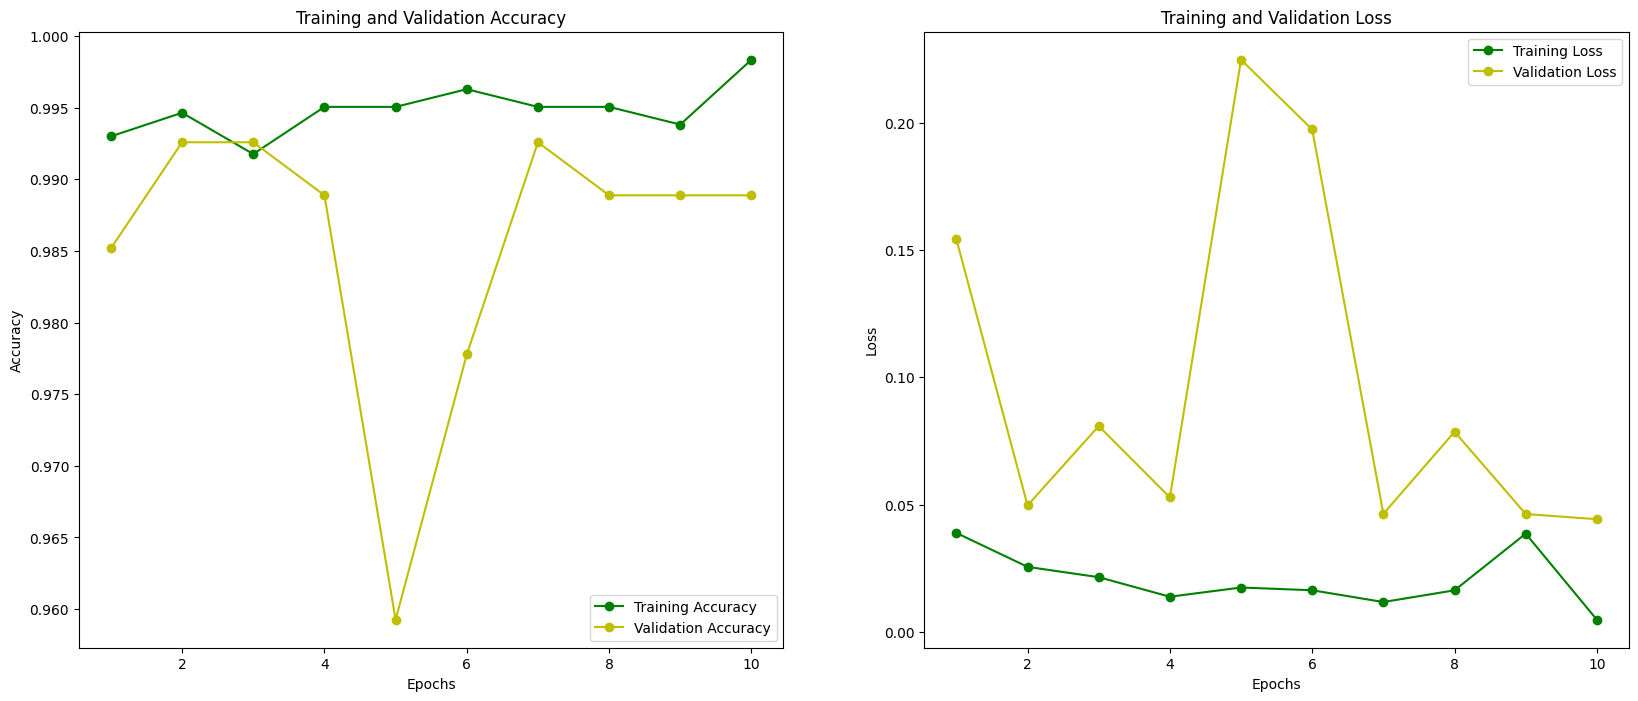

In [25]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc, 'g-o', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'y-o', label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'y-o', label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 815ms/step


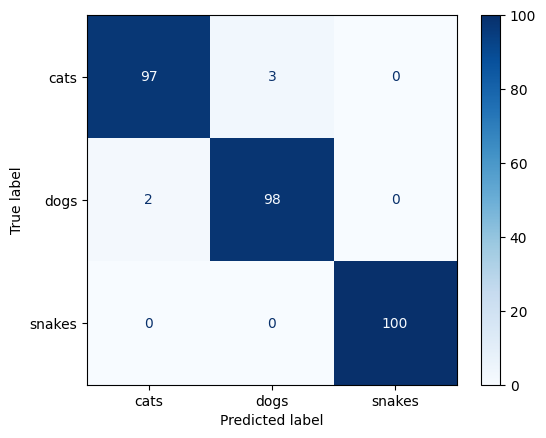

In [27]:
true_labels = []
for _, labels in test_ds:
    true_labels.extend(labels.numpy())

# Predict with the model
pred_probs = model.predict(test_ds)
pred_labels = np.argmax(pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.show()

In [28]:
# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict probabilities
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels (same order as test_ds batching)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# detailed report per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9826 - loss: 0.3217
Test Accuracy: 0.9900
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Precision: 0.9836, Recall: 0.9833, F1-score: 0.9833

Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.96      0.97       100
        dogs       0.96      0.99      0.98       100
      snakes       1.00      1.00      1.00       100

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9826 - loss: 0.3082
Test Accuracy: 0.9900
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step

Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.97      0.98       100
        dogs       0.97      0.99      0.98       100
      snakes       1.00      1.00      1.00       100

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



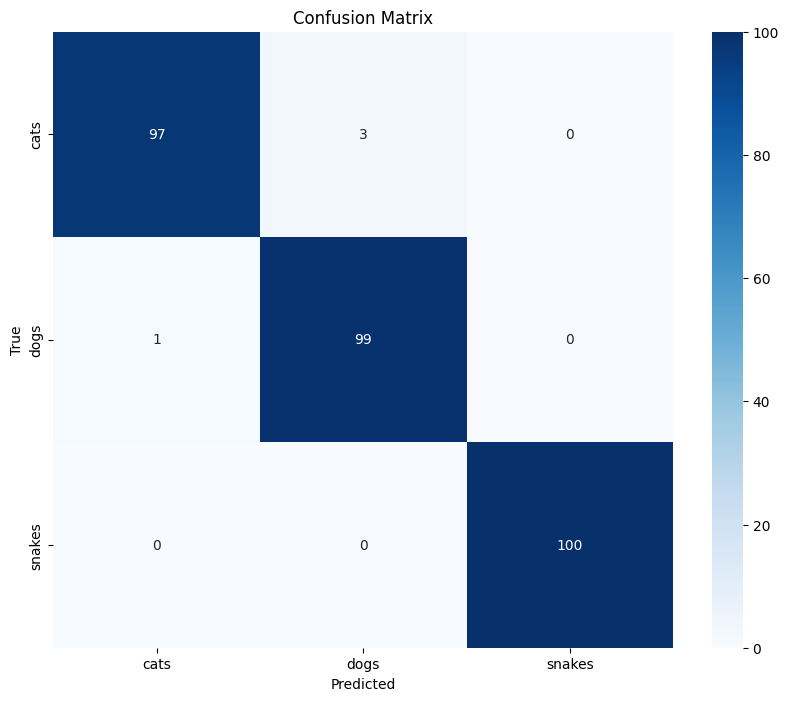

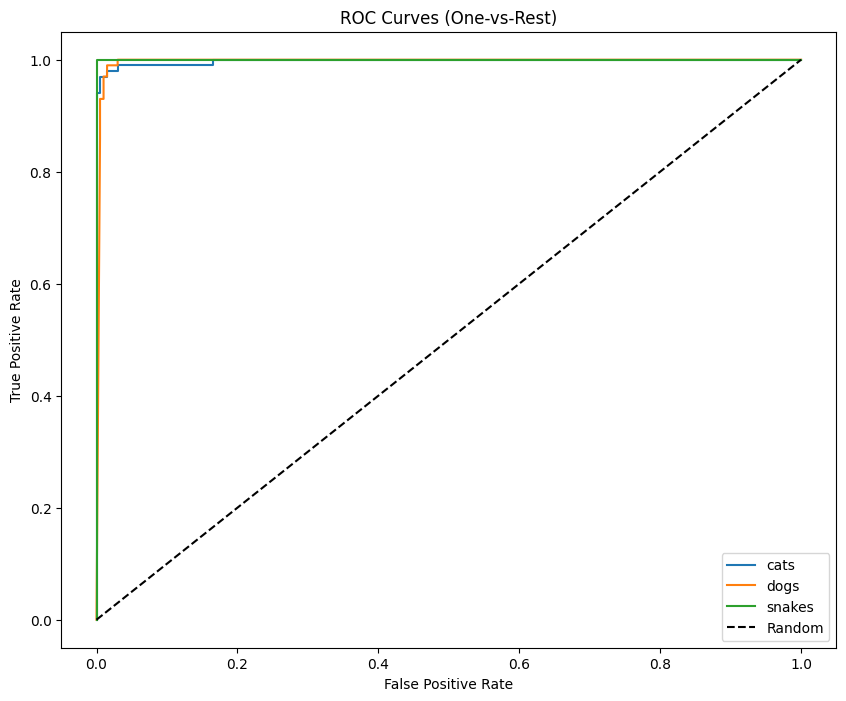

In [29]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_probs = model.predict(test_ds)  # shape: (num_samples, num_classes)
y_pred = np.argmax(y_probs, axis=1)

# True labels (extract from test_ds)
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC curve (multi-class, one-vs-rest)
y_true_bin = label_binarize(y_true, classes=np.arange(len(le.classes_)))  # binarized true labels

plt.figure(figsize=(10,8))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{le.classes_[i]}")
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.show()

In [30]:
# Predictions
y_probs = model.predict(test_ds)
y_pred = np.argmax(y_probs, axis=1)

# True labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Metrics per class
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=np.arange(len(le.classes_))
)

df_metrics = pd.DataFrame({
    'Class': le.classes_,   # use actual class names instead of 0,1,2,3
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'Support': support
})

# Sort by F1-score ascending
df_metrics_sorted = df_metrics.sort_values(by='F1-score')
print(df_metrics_sorted)

# Macro averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro'
)
print(f"\nMacro Avg -> Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-score: {f1_macro:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
    Class  Precision  Recall  F1-score  Support
0    cats   0.989583    0.95  0.969388      100
1    dogs   0.951923    0.99  0.970588      100
2  snakes   1.000000    1.00  1.000000      100

Macro Avg -> Precision: 0.9805, Recall: 0.9800, F1-score: 0.9800


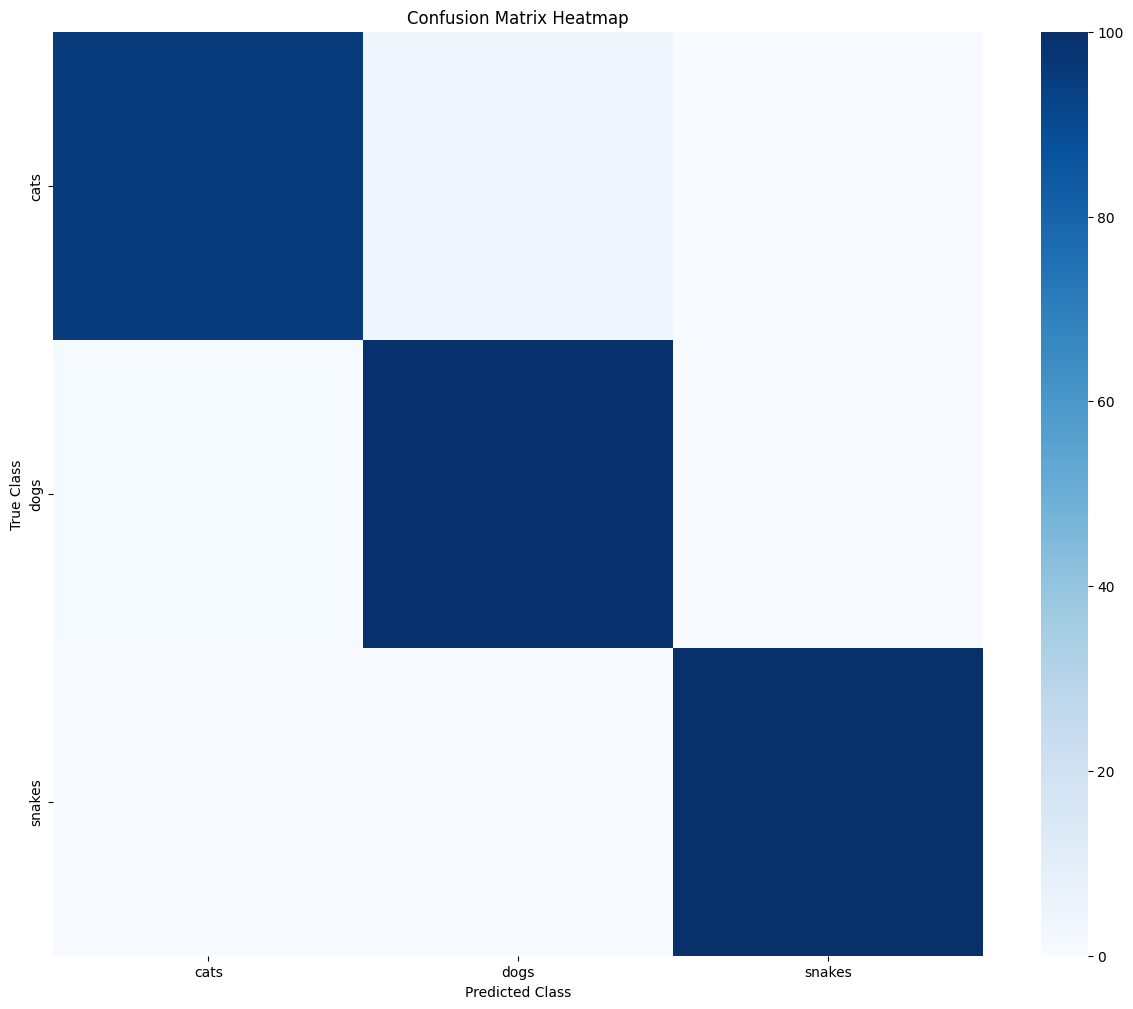

In [31]:
# Confusion matrix (no annotations, just intensity heatmap)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15,12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix Heatmap")
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


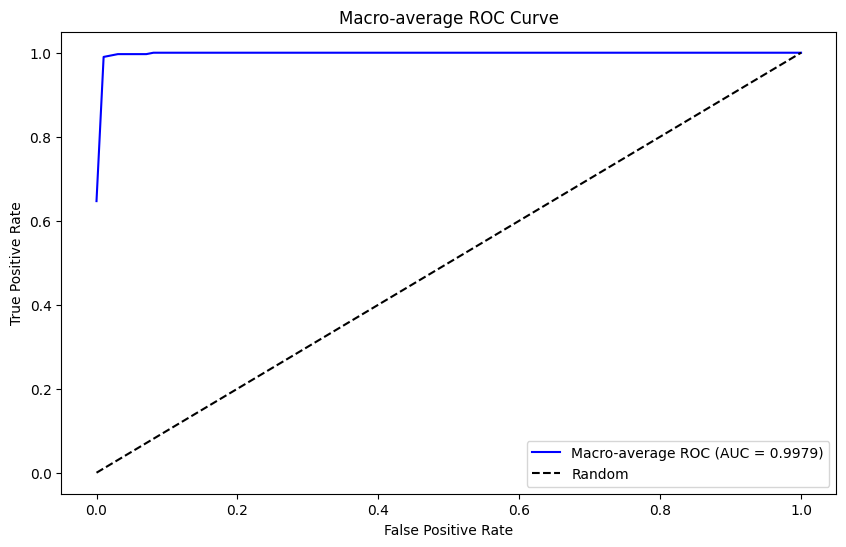

In [32]:
# Binarize true labels
y_test_bin = label_binarize(y_true, classes=np.arange(len(le.classes_)))

# Predict class probabilities
y_probs = model.predict(test_ds)

# Compute macro-average ROC
all_fpr = np.linspace(0, 1, 100)
mean_tpr = 0

for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)

mean_tpr /= len(le.classes_)
roc_auc = auc(all_fpr, mean_tpr)

# Plot
plt.figure(figsize=(10,6))
plt.plot(all_fpr, mean_tpr, color='b',
         label=f'Macro-average ROC (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend()
plt.show()

# **Saving the Model**

In [33]:
model.save("Simple_CNN_Classification.h5")
files.download("Simple_CNN_Classification.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>